In [2]:
# COMP 551, Fall 2024, McGill University
# Assignment 3
# Rob Li, Ian McFarland, Finnley Howald
# 18 November 2024

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

In [4]:
##### Task 1: Acquire the data

In [5]:
# pip install medmnist

In [6]:
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from medmnist import OrganAMNIST

import matplotlib.pyplot as plt
import time

In [7]:
### 1.1. Loading the dataset
raw_dataset = OrganAMNIST(split="train", download=True)

Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz


In [8]:
### 1.2. Checking dataset structure
print("Dataset Structure:")
print(f"Type: {type(raw_dataset)}")
print(f"Length: {len(raw_dataset)}")
print(f"Sample structure: {raw_dataset[0]}")

Dataset Structure:
Type: <class 'medmnist.dataset.OrganAMNIST'>
Length: 34561
Sample structure: (<PIL.Image.Image image mode=L size=28x28 at 0x1AF8DBFCA40>, array([6]))


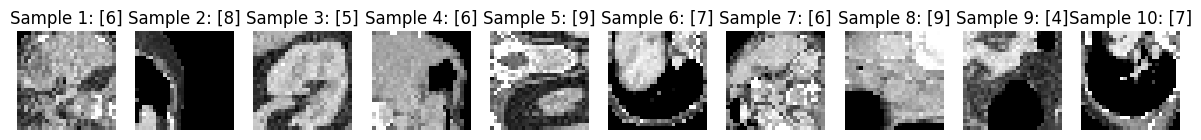

In [9]:
def show_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 7))
    for i in range(num_samples):
        image, label = dataset[i]  # Unpack the data (image and label)
        axes[i].imshow(image, cmap="gray")  # Display the image
        axes[i].set_title(f"Sample {i+1}: {label}")  # Display the label
        axes[i].axis("off")  # Hide axis for better view
    plt.show()

# Show 5 samples from the training dataset
show_samples(raw_dataset)

In [10]:
def mean_var_calc(tr="train"):
  transform = transforms.Compose([transforms.ToTensor()])
  data = OrganAMNIST(split=tr, download=True, transform=transform)
  loader = DataLoader(data, batch_size=1000, shuffle=False) # We could not pass the already loaded dataloader as transform will be different
  sum = 0.0
  squared_sum = 0.0
  N = 0
  for data, _ in loader: # Accumulative sum and std throughout data
    sum += data.sum(dim=[0, 2, 3])
    squared_sum += (data ** 2).sum(dim=[0, 2, 3])
    N += data.numel()
  mean = sum / N
  std = torch.sqrt((squared_sum / N) - (mean ** 2))
  return mean.item(), std.item()

In [11]:
train_mean, train_std = mean_var_calc()
test_mean, test_std = mean_var_calc("test")

Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz


In [12]:
print(train_mean, train_std)
print(test_mean, test_std)

0.4680282771587372 0.297420859336853
0.46014639735221863 0.2833701968193054


In [13]:
### 1.3. Loading the dataset as a flattened and normalized vector
transform_28 = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=train_mean, std=train_std),
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 28x28 image to 784
])

transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 28x28 image to 784
])

transform_128 = transforms.Compose([
    transforms.ToTensor(),                       # Convert PIL image to tensor
    transforms.Normalize(mean=test_mean, std=test_std),
    transforms.Resize(128),
    transforms.Lambda(lambda x: x.view(-1))      # Flatten the 128x128 image to 16384
])



# Load dataset with transformations applied
train_dataset = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_28)
test_dataset = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_28)

train_unnormalized_dataset = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_unnormalized)
test_unnormalized_dataset = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_unnormalized)

train_dataset_128 = medmnist.dataset.OrganAMNIST(split="train", download=True, transform=transform_128)
test_dataset_128 = medmnist.dataset.OrganAMNIST(split="test", download=True, transform=transform_128)

# Create a DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_unnormalized_loader = DataLoader(train_unnormalized_dataset, batch_size=batch_size, shuffle=True)
test_unnormalized_loader = DataLoader(test_unnormalized_dataset, batch_size=batch_size, shuffle=True)

train_loader_128 = DataLoader(train_dataset_128, batch_size=batch_size, shuffle=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=batch_size, shuffle=True)

# Check a batch to ensure transformations are applied correctly
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")  # Expected shape: [batch_size, 784]
print(f"Batch of labels shape: {labels.shape}")

Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Ian\.medmnist\organamnist.npz
Batch of images shape: torch.Size([64, 784])
Batch of labels shape: torch.Size([64, 1])


In [14]:
X_train, Y_train, X_train_unnormalized, Y_train_unnormalized, X_train_128, Y_train_128 = [], [], [], [], [], []
X_test, Y_test, X_test_unnormalized, Y_test_unnormalized, X_test_128, Y_test_128 = [], [], [], [], [], []
for images, labels in train_loader:
  X_train.append(images.numpy())
  Y_train.append(labels.numpy())
for images, labels in test_loader:
  X_test.append(images.numpy())
  Y_test.append(labels.numpy())

for images, labels in train_unnormalized_loader:
  X_train_unnormalized.append(images.numpy())
  Y_train_unnormalized.append(labels.numpy())
for images, labels in test_unnormalized_loader:
  X_test_unnormalized.append(images.numpy())
  Y_test_unnormalized.append(labels.numpy())

for images, labels in train_loader_128:
  X_train_128.append(images.numpy())
  Y_train_128.append(labels.numpy())

for images, labels in test_loader_128:
  X_test_128.append(images.numpy())
  Y_test_128.append(labels.numpy())

X_train = np.concatenate(X_train, axis=0)
Y_train = np.concatenate(Y_train, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0).squeeze()

X_train_unnormalized = np.concatenate(X_train_unnormalized, axis=0)
Y_train_unnormalized = np.concatenate(Y_train_unnormalized, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test_unnormalized = np.concatenate(X_test_unnormalized, axis=0)
Y_test_unnormalized = np.concatenate(Y_test_unnormalized, axis=0).squeeze()

X_train_128 = np.concatenate(X_train_128, axis=0)
Y_train_128 = np.concatenate(Y_train_128, axis=0).squeeze()  # squeeze to remove extra dimension if needed
X_test_128 = np.concatenate(X_test_128, axis=0)
Y_test_128 = np.concatenate(Y_test_128, axis=0).squeeze()


def one_hot_encode(y, num_classes=11):
  one_hot = np.zeros((y.size, num_classes))
  one_hot[np.arange(y.size), y] = 1
  return one_hot

Y_train_encoded = one_hot_encode(Y_train)
Y_test_encoded = one_hot_encode(Y_test)

Y_train_unnormalized_encoded = one_hot_encode(Y_train_unnormalized)
Y_test_unnormalized_encoded = one_hot_encode(Y_test_unnormalized)

Y_train_128_encoded = one_hot_encode(Y_train_128)
Y_test_128_encoded = one_hot_encode(Y_test_128)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_train_encoded shape: {Y_train_encoded.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"Y_test_encoded shape: {Y_test_encoded.shape}")

print(f"X_train_unnormalized shape: {X_train_unnormalized.shape}")
print(f"Y_train_unnormalized shape: {Y_train_unnormalized.shape}")
print(f"Y_train_unnormalized_encoded shape: {Y_train_unnormalized_encoded.shape}")
print(f"X_test_unnormalized shape: {X_test_unnormalized.shape}")
print(f"Y_test_unnormalized shape: {Y_test_unnormalized.shape}")
print(f"Y_test_unnormalized_encoded shape: {Y_test_unnormalized_encoded.shape}")

print(f"X_train_128 shape: {X_train_128.shape}")
print(f"Y_train_128 shape: {Y_train_128.shape}")
print(f"Y_train_128_encoded shape: {Y_train_128_encoded.shape}")
print(f"X_test_128 shape: {X_test_128.shape}")
print(f"Y_test_128 shape: {Y_test_128.shape}")
print(f"Y_test_128_encoded shape: {Y_test_128_encoded.shape}")

# Y encoded is for training purposes in the fit function
# Use Y raw for accuracy evalation and testing as the model's final prediction is just the class number

X_train shape: (34561, 784)
Y_train shape: (34561,)
Y_train_encoded shape: (34561, 11)
X_test shape: (17778, 784)
Y_test shape: (17778,)
Y_test_encoded shape: (17778, 11)
X_train_unnormalized shape: (34561, 784)
Y_train_unnormalized shape: (34561,)
Y_train_unnormalized_encoded shape: (34561, 11)
X_test_unnormalized shape: (17778, 784)
Y_test_unnormalized shape: (17778,)
Y_test_unnormalized_encoded shape: (17778, 11)
X_train_128 shape: (34561, 16384)
Y_train_128 shape: (34561,)
Y_train_128_encoded shape: (34561, 11)
X_test_128 shape: (17778, 16384)
Y_test_128 shape: (17778,)
Y_test_128_encoded shape: (17778, 11)


In [16]:
# acost perry for
# min max vs real mean var
# random seed

In [15]:
# Activation function library
def softmax(z):
  exps = np.exp(z)
  return exps / np.sum(exps, axis=1, keepdims=True)

class ActivationFunction:
    def function(self, x):
        raise NotImplementedError("Function method not implemented.")

    def derivative(self, x):
        raise NotImplementedError("Derivative method not implemented.")

class ReLU(ActivationFunction):
    def function(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return np.where(x > 0, 1, 0)
    
class LeakyReLU(ActivationFunction):
    def function(self, x):
        return np.where(x > 0, x, x * 0.01)
    def derivative(self, x):
        return np.where(x > 0, 1, 0.01)

class Sigmoid(ActivationFunction):
    def function(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        sig = self.function(x)
        return sig * (1 - sig)

class Tanh(ActivationFunction):
    def function(self, x):
        return np.tanh(x)

    def derivative(self, x):
        return 1 - np.tanh(x) ** 2
    
logistic = lambda z: 1./ (1 + np.exp(-z))


In [ ]:
##### Task 2: Implement a Multilayer Perceptron
class MultilayerPerceptron:

  def __init__(self, activation_function = ReLU, hidden_layers = 2, hidden_layer_widths = [64,64], input_width = 784, output_width = 11, regularization = None, regularization_lambda = 0.01, print_loss = False, normalized = True, big_images = False):
    if (len(hidden_layer_widths) != hidden_layers):
      raise ValueError("Number of hidden layers does not match the size of layer_widths in MultilayerPerceptron initalization")
    
    self.activation_function = activation_function
    self.regularization = regularization
    self.regularization_lambda = regularization_lambda
    self.print_loss = print_loss
    layer_sizes = [input_width] + hidden_layer_widths + [output_width]
    self.weights = []
    self.biases = []
    self.epoch_losses = []
    self.losses = []
    self.hidden_layers = hidden_layers
    self.normalized = normalized
    self.big_images = big_images
    self.training_time = 0

    for i in range (len(layer_sizes) - 1):
      weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
      self.weights.append(weight_matrix)
      bias_vector = np.zeros((1, layer_sizes[i + 1]))
      self.biases.append(bias_vector)

  def calculate_loss(self, Y, Y_hat):
    # Cross-entropy loss
    data_loss = -np.mean(np.sum(Y * np.log(Y_hat + 1e-8), axis=1))
    regularization_loss = 0

    if self.regularization == "L2":
        for weight in self.weights:
            regularization_loss += 0.5 * self.regularization_lambda * np.sum(weight * weight)
    elif self.regularization == "L1":
        for weight in self.weights:
            regularization_loss += self.regularization_lambda * np.sum(np.abs(weight))

    # Total loss
    total_loss = data_loss + regularization_loss
    return total_loss
  
  def plot_loss(self):
      epochs = range(1, len(self.losses) + 1)
      plt.figure(figsize=(10, 6))
      plt.plot(epochs, self.losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss (Cross-Entropy in %)')
      plt.title('Loss vs Epoch')
      plt.legend()
      plt.grid(True)
      plt.show()

  def print(self):
    if self.regularization:
      if self.normalized:
        if self.big_images:
          print(f'Model: {self.hidden_layers} hidden layers, {self.activation_function.__name__} activation function, {self.regularization} regularization and lambda = {self.regularization_lambda} with normalized data and 128x128 images')
        else:
          print(f'Model: {self.hidden_layers} hidden layers, {self.activation_function.__name__} activation function, {self.regularization} regularization and lambda = {self.regularization_lambda}')
      else:
        print(f'Model: {self.hidden_layers} hidden layers, {self.activation_function.__name__} activation function, {self.regularization} regularization and lambda = {self.regularization_lambda} with unnormalized data')
    else:
      if self.normalized:
        print(f'Model: {self.hidden_layers} hidden layers, {self.activation_function.__name__} activation function, and no regularization')
      else:
        print(f'Model: {self.hidden_layers} hidden layers, {self.activation_function.__name__} activation function, and no regularization with unnormalized data')
    self.plot_loss()
    print(f"Training time: {self.training_time:.4f} seconds")

  def fit(self, X, Y, learning_rate = 0.01, epochs = 1e4, batch_size = 32):
    start_time = time.time()

    N, D = X.shape

    for epoch in range(epochs):
      self.epoch_losses = []

      # Batch splitting
      indicies = np.arange(N)
      np.random.shuffle(indicies)
      X = X[indicies]
      Y = Y[indicies]

      for index in range(0, N, batch_size):
        X_batch = X[index:index+batch_size]
        Y_batch = Y[index:index+batch_size]

        # Activations
        activations = [X_batch]
        Z_values = []

        # Forward Pass
        for j in range(len(self.weights)):
          Z = np.dot(activations[-1], self.weights[j]) + self.biases[j]
          Z_values.append(Z)

          if j < len(self.weights) - 1: # Hidden Layers 
            A = self.activation_function.function(self, Z)
            
          else: # Output Layer
            A = softmax(Z)

          activations.append(A)

        # Loss Calculation
        loss = self.calculate_loss(activations[-1], Y_batch)
        self.epoch_losses.append(loss)

        # Backward Pass
        dLdAj = activations[-1] - Y_batch  # For Loss partial with softmax simplified under cross-entropy (yhat - y)

        if len(self.weights) == 1: 
          for j in reversed(range(len(self.weights))):
            dLdZj = dLdAj
            dLdWj = np.dot(activations[j].T, dLdZj) / batch_size # Partial of Loss w/resp to weight at layer j Wj
            dLdBj = np.sum(dLdZj, axis=0, keepdims=True) / batch_size # Partial of Loss w/resp to Bias at j Bj
            # Update weights and biases
            self.weights[j] -= learning_rate * dLdWj
            self.biases[j] -= learning_rate * dLdBj
        
        else: 
          for j in reversed(range(1, len(self.weights))):
            dLdZj = dLdAj
            
            dLdWj = np.dot(activations[j].T, dLdZj) / batch_size # Partial of Loss w/resp to weight at layer j Wj
            dLdBj = np.sum(dLdZj, axis=0, keepdims=True) / batch_size # Partial of Loss w/resp to Bias at j Bj

            if self.regularization == "L2":
              dLdWj += self.regularization_lambda * self.weights[j]
            elif self.regularization == "L1":
              dLdWj += self.regularization_lambda * np.sign(self.weights[j])
            
            if j > 0:
              dLdAj = np.dot(dLdZj, self.weights[j].T) * self.activation_function.derivative(self, Z_values[j-1]) # Partial of Loss w/resp to activation at j Aj

            # Update weights and biases
            self.weights[j] -= learning_rate * dLdWj
            self.biases[j] -= learning_rate * dLdBj

      self.losses.append(np.mean(self.epoch_losses))
      #print(f"Epoch {epoch}, Loss: {np.mean(self.epoch_losses)}")

    self.training_time = time.time() - start_time
    return self

  def predict(self, X):
    A = X

    for j in range(len(self.weights)):
      Z = np.dot(A, self.weights[j]) + self.biases[j]

      if j < len(self.weights) - 1:
        A = self.activation_function.function(self, Z)

      else:
        A = softmax(Z)

    return np.argmax(A, axis=1)


In [17]:
def evaluate_acc(y, y_hat):
  if len(y) != len(y_hat):
    raise ValueError("Size mismatch: y and y_hat must have the same length in evaluate_acc.")
  # Calculate the mean of correct predictions
  accuracy = np.mean(y == y_hat)
  return accuracy * 100

Model: 0 hidden layers, ReLU activation function, and no regularization


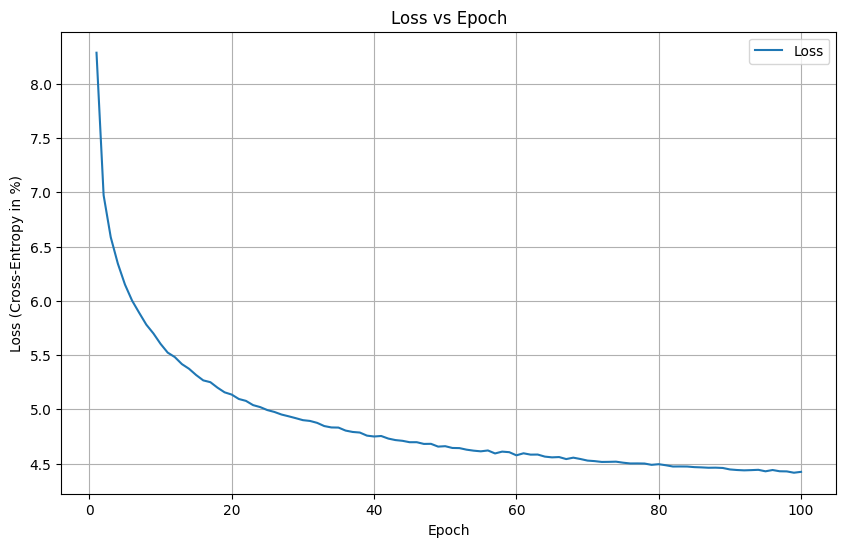

Training time: 9.7425 seconds
Accuracy of model 1: 58.055%
-------------------------------
 
Model: 1 hidden layers, ReLU activation function, and no regularization


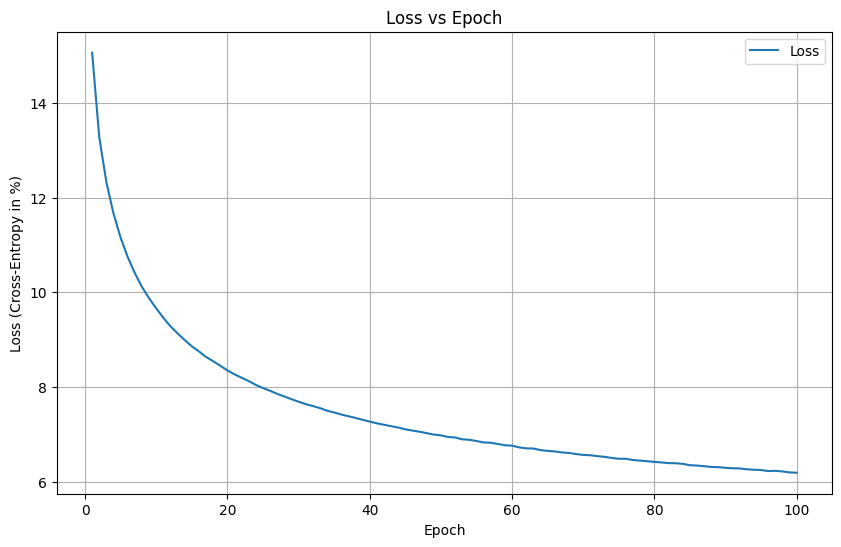

Training time: 26.0213 seconds
Accuracy of model 2: 66.774%
Model: 2 hidden layers, ReLU activation function, and no regularization


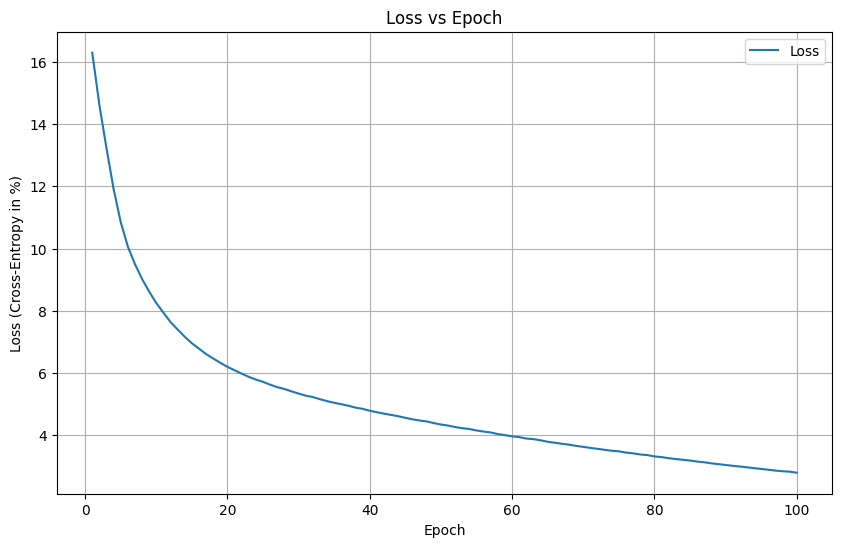

Training time: 61.7511 seconds
Accuracy of model 3: 71.026%


In [ ]:
# 3.1 

# MLP no hidden layers
mlp = MultilayerPerceptron(hidden_layers=0, hidden_layer_widths=[], print_loss=False)
mlp.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat = mlp.predict(X_test)
accuracy = evaluate_acc(Y_test, Y_hat)
mlp.print()
print(f"Accuracy of model 1: {accuracy:.3f}%")

print("-------------------------------")
print(" ")

# MLP 1 hidden layer, 256 and ReLU
mlp2 = MultilayerPerceptron(hidden_layers=1, hidden_layer_widths=[256])
mlp2.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat2 = mlp2.predict(X_test)
accuracy2 = evaluate_acc(Y_test, Y_hat2)
mlp2.print()
print(f"Accuracy of model 2: {accuracy2:.3f}%")

print("-------------------------------")
print(" ")

# MLP 2 hidden layers, 256 and ReLU
mlp3 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256])
mlp3.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat3 = mlp3.predict(X_test)
accuracy3 = evaluate_acc(Y_test, Y_hat3)
mlp3.print()
print(f"Accuracy of model 3: {accuracy3:.3f}%")

Model: 2 hidden layers, Tanh activation function, and no regularization


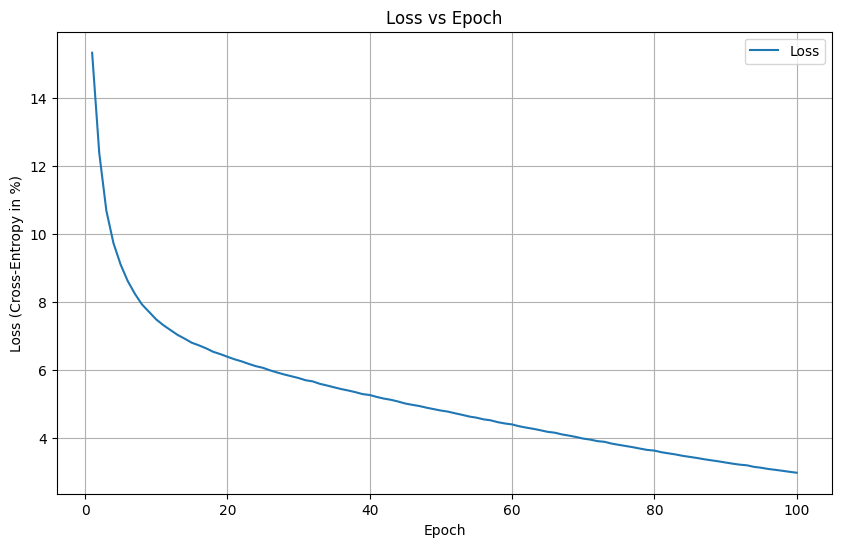

Training time: 89.8831 seconds
Accuracy of model 4: 69.946%
-------------------------------
 
Model: 2 hidden layers, LeakyReLU activation function, and no regularization


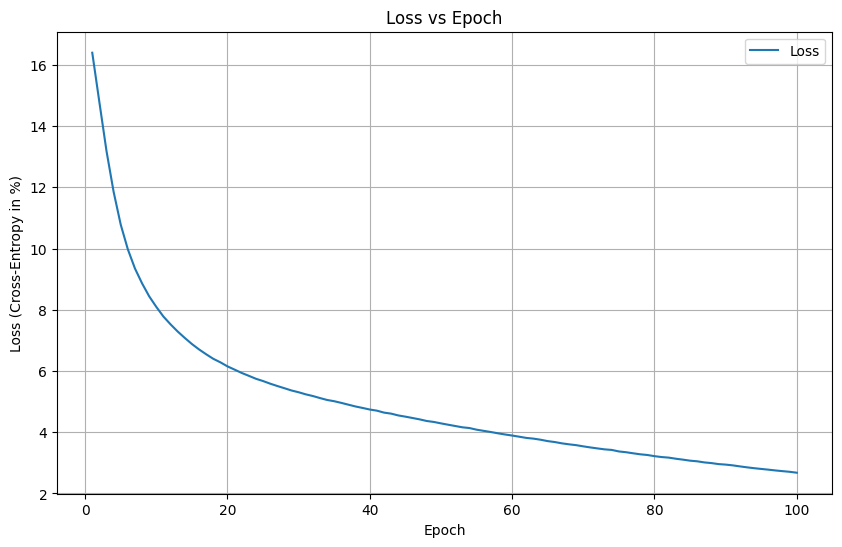

Training time: 59.7655 seconds
Accuracy of model 5: 70.418%


In [67]:
# 3.2: 2 Layer MLPs, now using TanH and Leaky ReLU
mlp4 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], activation_function=Tanh)
mlp4.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat4 = mlp4.predict(X_test)
accuracy4 = evaluate_acc(Y_test, Y_hat4)
mlp4.print()
print(f"Accuracy of model 4: {accuracy4:.3f}%")

print("-------------------------------")
print(" ")

mlp5 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], activation_function=LeakyReLU)
mlp5.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat5 = mlp5.predict(X_test)
accuracy5 = evaluate_acc(Y_test, Y_hat5)
mlp5.print()
print(f"Accuracy of model 5: {accuracy5:.3f}%")


Model: 2 hidden layers, ReLU activation function, L1 regularization and lambda = 0.001


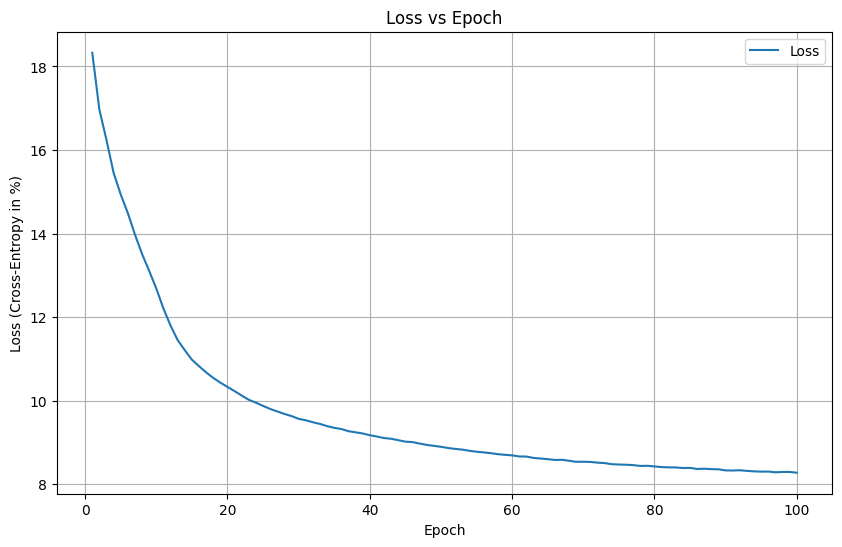

Training time: 134.2372 seconds
Accuracy of model 6: 65.221%
-------------------------------
 
Model: 2 hidden layers, ReLU activation function, L2 regularization and lambda = 0.001


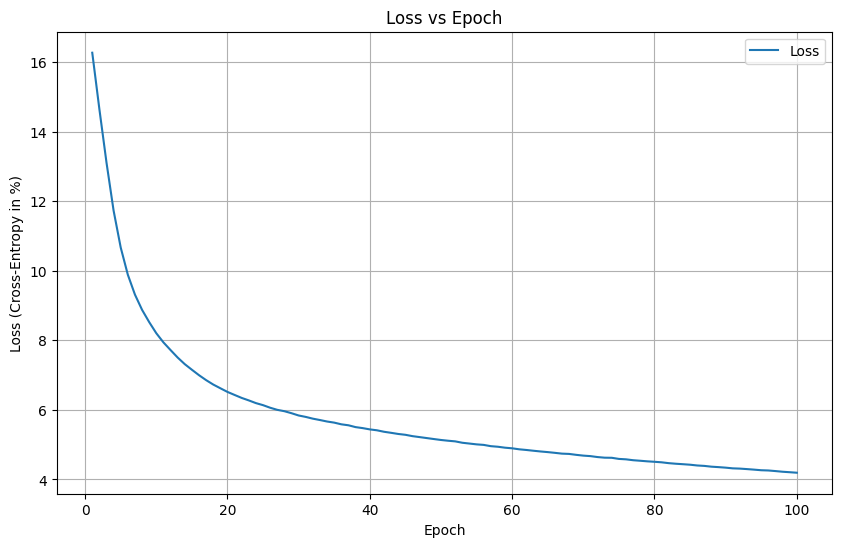

Training time: 102.9026 seconds
Accuracy of model 7: 70.852%


In [68]:
# 3.3 2 Layer MLPs, now using L1 and L2 regularization

mlp6 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L1", regularization_lambda=0.001)
mlp6.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat6 = mlp6.predict(X_test)
accuracy6 = evaluate_acc(Y_test, Y_hat6)
mlp6.print()
print(f"Accuracy of model 6: {accuracy6:.3f}%")

print("-------------------------------")
print(" ")

mlp7 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L2", regularization_lambda=0.001)
mlp7.fit(X_train, Y_train_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat7 = mlp7.predict(X_test)
accuracy7 = evaluate_acc(Y_test, Y_hat7)
mlp7.print()
print(f"Accuracy of model 7: {accuracy7:.3f}%")

In [ ]:
# 3.4 Unnormalized data
mlp9 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L1", regularization_lambda=0.001)
mlp9.fit(X_train_unnormalized, Y_train_unnormalized_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat9 = mlp9.predict(X_test_unnormalized)
accuracy9 = evaluate_acc(Y_test_unnormalized, Y_hat9)
mlp9.print()
print(f"Accuracy of model 9: {accuracy9:.3f}%")

print("-------------------------------")
print(" ")

mlp8 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], regularization="L2", regularization_lambda=0.001)
mlp8.fit(X_train_unnormalized, Y_train_unnormalized_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat8 = mlp8.predict(X_test_unnormalized)
accuracy8 = evaluate_acc(Y_test_unnormalized, Y_hat8)
mlp8.print()
print(f"Accuracy of model 8: {accuracy8:.3f}%")


In [ ]:
# 3.5 128x128 images

# No regularization
mlp10 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], input_width=16384)
mlp10.fit(X_train_128, Y_train_128_encoded, learning_rate=0.01, epochs=100, batch_size=32)
Y_hat10 = mlp10.predict(X_test_128)
accuracy10 = evaluate_acc(Y_test_128, Y_hat10)
mlp10.print()
print(f"Accuracy of model 10: {accuracy10:.3f}%")

print("-------------------------------")
print(" ")

# L1 regularization
mlp11 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], input_width=16384, regularization="L1", regularization_lambda=0.001)
start_time = time.time()
mlp11.fit(X_train_128, Y_train_128_encoded, learning_rate=0.01, epochs=100, batch_size=32)
time_to_train = time.time() - start_time
Y_hat11 = mlp11.predict(X_test_128)
accuracy11 = evaluate_acc(Y_test_128, Y_hat11)
mlp11.print()
print(f"Accuracy of model 11: {accuracy11:.3f}%")

print("-------------------------------")
print(" ")

# L2 regularization
mlp12 = MultilayerPerceptron(hidden_layers=2, hidden_layer_widths=[256, 256], input_width=16384, regularization="L2", regularization_lambda=0.001)
start_time = time.time()
mlp12.fit(X_train_128, Y_train_128_encoded, learning_rate=0.01, epochs=100, batch_size=32)
time_to_train = time.time() - start_time
Y_hat12 = mlp12.predict(X_test_128)
accuracy12 = evaluate_acc(Y_test_128, Y_hat12)
mlp12.print()
print(f"Accuracy of model 12: {accuracy12:.3f}%")

73.25345933175835
Time to train: 377.54753255844116
